Using device: cuda

Final Metrics:
MSE: 299723075.6014
MAE: 12148.7328
RMSE: 17312.5121
MAPE: 3.1451


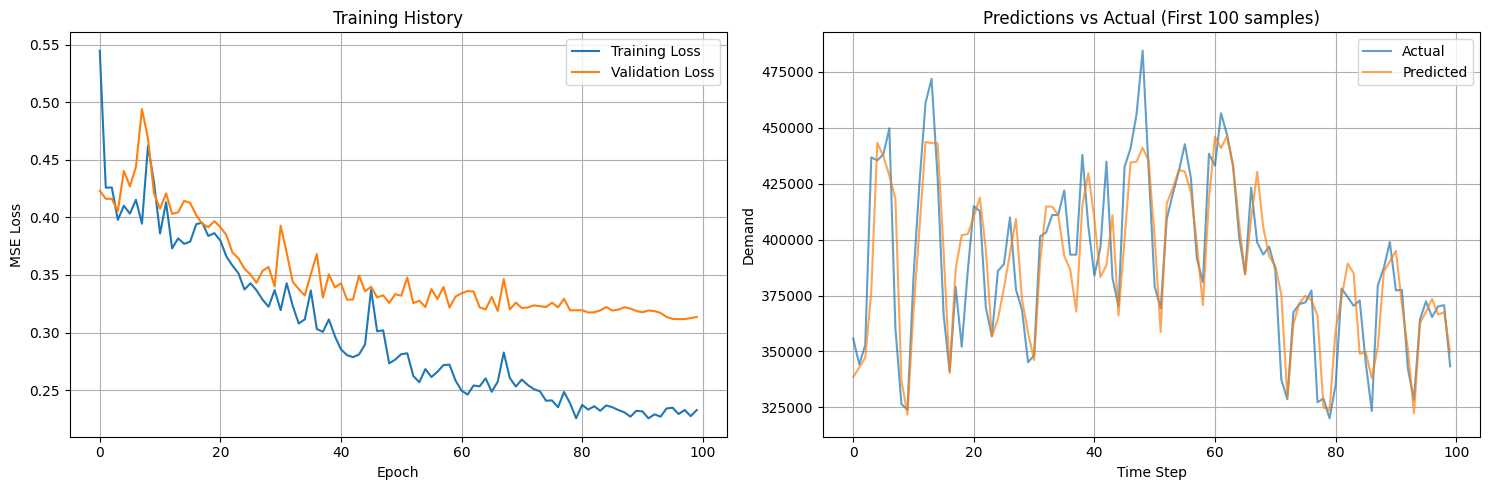

In [1]:
#imports
from model import *

params = {
        'learning_rate': 0.001,
        'batch_size': 32,
        'seq_length': 7,
        'transformer_encoder_layer_params': {
            'd_model': 64,
            'nhead': 4,
            'dim_feedforward': 256,
            'dropout': 0.1,
            'activation': 'relu'
        },
        'transformer_layer_params': {
            'num_layers': 2,
        },
        'dataset': '2016-2019',
        'train_test_split': 'prior:2019'
    }

sequences, targets, datetimes, scaler = prepare_data(params)


model, train_losses, val_losses = train_transformer_model(
    sequences.numpy(), targets.numpy(), input_dim, datetimes, params
)

postprocess(model, sequences, targets, scaler, train_losses, val_losses)
